## Polynomial Regression
Apply polynomial regression on real-world problem which has multi-dimension on input data.</br>

##### Data
There are 3 classes of 50 instances for each. </br>
The first 40 samples of each class are used as training set, and the last 10 samples as testing set.</br>

**Number of attributes**: 5 (4-dim input (data), 1-dim targrt (class-label))

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import pinv,inv,matrix_power
from scipy.io import loadmat
import itertools

### Load and preprocess data

In [2]:
data_dir = './data/'
x = loadmat(data_dir+'5_X.mat')['X']
t = loadmat(data_dir+'5_T.mat')['T']
# print(tr)
# print(ts)

x_dim = 4
t_dim = 1
n_per_class = 50 
class_n = 3

# prepare to divide into training and testing
x = x.reshape(class_n,n_per_class,x_dim)
t = t.reshape(class_n,n_per_class)

# divide into train and test
tr_n_per_class = 40
ts_n_per_class = 10
tr_x = np.zeros((tr_n_per_class*class_n , x_dim))
ts_x = np.zeros((ts_n_per_class*class_n , x_dim))
tr_t = np.zeros(tr_n_per_class*class_n)
ts_t = np.zeros(ts_n_per_class*class_n)
for cls in range(class_n):
    tr_x[(cls)*tr_n_per_class:(cls+1)*tr_n_per_class] = x[cls][:tr_n_per_class]
    ts_x[(cls)*ts_n_per_class:(cls+1)*ts_n_per_class] = x[cls][tr_n_per_class:]
    tr_t[(cls)*tr_n_per_class:(cls+1)*tr_n_per_class] = t[cls][:tr_n_per_class]
    ts_t[(cls)*ts_n_per_class:(cls+1)*ts_n_per_class] = t[cls][tr_n_per_class:]

N_tr = len(tr_t)
N_ts = len(ts_t)

print('Finish preprocess of data')

Finish preprocess of data


### (1) Apply regression for class estimation by minimizing the non-regularized error function

The error function looks like below:

$$E(w) = \frac{1}{2}*\sum_{n=1}^{N}(y(x_n,w)-t_n)^{2} $$

However, since our input, x, now turn to be multi-dimension, the polynomial function should be generalized, here is an example of order=2 (**M=2**):


$$y(x,w) = w_0 + \sum_{i=1}^{D}w_i*x_i + \sum_{i=1}^{D}\sum_{j=1}^{D}w_{ij}*x_i*x_j $$

note that in this problem, the dimension, D, equals to 4. </br>
##### Here we apply order M = 1 and M = 2.

In [3]:
'''
compare to preoblem4, the only difference is the form of 'phi', o.w. the other stuffs like the solution of W still 
equals to (phi^T * phi)^-1 * phi^T * t.
phi = [[x1^0,x1^1....x1^M],[x2^0,x2^1....x2^M], .... [xN^0,xN^1....xN^M]], while each x1, x2, ... xN are all in 
'Vector' form.
t = [t1,t2,t3 ... ,tN], which are just 'class-label' of each xN
'''
# Recursive produce power of vector
def helper(data,m):
    if m < 1:
        return np.asarray([[1]]) # [[x1^{0}],[x2^{0}], ... ,[xN^{0}]]
    else:
        return np.asarray([[x*y for y in data] for x in helper(data,m-1)[0]]) # recursively create the power of x-vector
    
def CreatePowerMat(high_dim_data,m):
    lst = []
    high_dim_data = list(high_dim_data)
    for i in range(m+1):
        mat = helper(high_dim_data,i)
        lst = lst + list(mat.reshape(1,-1)[0])
    return lst

# Use pseudo inverse to calculate best-weight(W)
def Cal_W(tr_x, M, x_dim):
    Phi_mat = [list(x) for x in np.zeros((N_tr,1))] # initial
    T = np.zeros((N_tr,1))
    W = []

    for r_idx in range(N_tr):
        Phi_mat[r_idx] = CreatePowerMat(tr_x[r_idx],M)
        T[r_idx][0] = tr_t[r_idx]

    Phi_mat = np.asarray(Phi_mat)
    
    # Start calculating W result
    W = np.dot( pinv(Phi_mat) , T)
    
    # Save w-vector power in global-variable and later use in y(x,w)
    s_p = 0
    for i in range(M+1):
        size_w = x_dim**i
        W_mat.append(W[s_p:s_p+size_w])
        s_p += size_w
    
    return W
          
# Root mean square
def poly_func (input_data, m):
    val = 0    
    for i in range(m+1): 
        # create x-vec power
        x_ = helper(input_data,i)
        x_ = x_.reshape(1,-1)[0]

        # retrieve data from pre-saved W
        w_ = W_mat[i].reshape(1,-1)[0]

        # calculate y-func value
        val += np.sum(x_ * w_)

    return val

def Cal_rms(length, input_data, target_data, W, m):
    Err = 0
    for n in range(length):
        # careful on the transpose result have to index into it again
        Err += (poly_func(input_data[n], m) - target_data[n])**2 
    Err /= 2
    RMS_err = np.sqrt((2*Err)/length)

    return RMS_err
    
    
# Main Function
tr_rms_ary = []
ts_rms_ary = []
Ms = [1,2]
for M in Ms:
    W_mat = []
    Best_W = Cal_W(tr_x, M, x_dim)
    RMS_err_tr = Cal_rms(N_tr, tr_x, tr_t, Best_W, M)
    RMS_err_ts = Cal_rms(N_ts, ts_x, ts_t, Best_W, M)
    tr_rms_ary.append(RMS_err_tr)
    ts_rms_ary.append(RMS_err_ts)
    
    print('training rms-Err for M = %s is %s.' % (str(M),str(RMS_err_tr)))
    print('testing rms-Err for M = %s is %s.' % (str(M),str(RMS_err_ts)))
    print('==============================================')

training rms-Err for M = 1 is 0.226279143015.
testing rms-Err for M = 1 is 0.171124893337.
training rms-Err for M = 2 is 0.188594629096.
testing rms-Err for M = 2 is 0.153232445343.


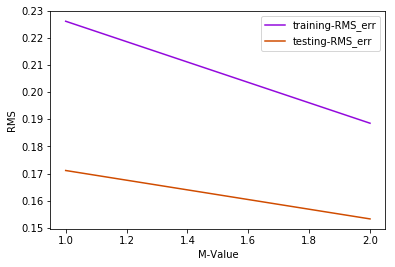

In [4]:
# visualize result
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,len(Ms)+1),tr_rms_ary ,color=colors[1], label='training-RMS_err'.format(i=0))
plt.plot(range(1,len(Ms)+1),ts_rms_ary ,color=colors[2], label='testing-RMS_err'.format(i=1))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
# plt.axis([0, 6, 0, 20])
plt.legend(loc='best')
plt.xlabel('M-Value')
plt.ylabel('RMS')
plt.savefig('./OutputFigure/hw1-5-(1)_non_regularize_multi-dim.png')

plt.show()
plt.close(fig)

### (2) Select most contributive attribute
Apply polynomials of order M=2 and select the most contributive attribute. (lowest RMS error on training set)

In [5]:
#Find a best attribute
    
tr_rms_ary = []
M = 2
Min_rms_attri = None
better_tr_RMS = -np.inf
choices = [0,1,2,3]
keep_dim = 3
for choice in choices:
    
    # extract attribute
    
    attri_lst = [0,1,2,3]
    attri_lst.remove(choice)
    tr_x_d = tr_x[:,attri_lst].reshape(N_tr,-1)

    # calculate best weight
    W_mat = []
    Best_W = Cal_W(tr_x_d, M, keep_dim)
    RMS_err_tr = Cal_rms(N_tr, tr_x_d, tr_t, Best_W, M)
    print('training rms-Err for removing Column-Index = %s is %s.' % (str(choice),str(RMS_err_tr)))

    # find best RMS within same dimension
    if RMS_err_tr > better_tr_RMS:
        better_tr_RMS = RMS_err_tr
        Min_rms_attri = choice

    tr_rms_ary.append(RMS_err_tr)

print('=============================================================')
print('Worse rms-Err is %s. Happenend in removing attribute %s.'%(str(better_tr_RMS),str(Min_rms_attri)))
print('=============================================================')
print('=============================================================')

training rms-Err for removing Column-Index = 0 is 0.209939408751.
training rms-Err for removing Column-Index = 1 is 0.208753917438.
training rms-Err for removing Column-Index = 2 is 0.225311937506.
training rms-Err for removing Column-Index = 3 is 0.213847493016.
Worse rms-Err is 0.225311937506. Happenend in removing attribute 2.


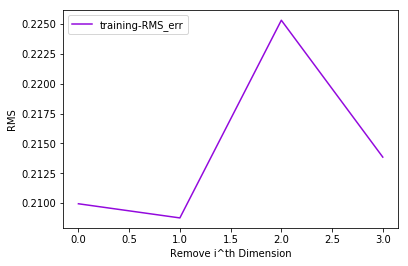

As the Figure show, we will choose attributes 2(start from 0). Since without this attribute, it goes to worst RMS value, 0.225311937506 .


In [6]:
# visualize result
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(0,4),tr_rms_ary ,color=colors[1], label='training-RMS_err'.format(i=0))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
# plt.axis([0, 6, 0, 20])
plt.legend(loc='best')
plt.xlabel('Remove i^th Dimension')
plt.ylabel('RMS')
plt.savefig('./OutputFigure/hw1-5-(2)_atribute_decision.png')

plt.show()
plt.close(fig)
print('As the Figure show, we will choose attributes %d(start from 0). Since without this attribute, it goes to worst RMS value, %s .' % (Min_rms_attri,str(better_tr_RMS)))

### The following part is not required in this assignment
I want to see how many dimensions can achieve the best RMS-error, so I test on all combinations from 1 dimension to 4 dimensions.

In [7]:
# Other additional work, not required in this assignment.
# Test on how many dimension of data achieve best RMS
    
tr_rms_ary = []
ts_rms_ary = []
M = 2
Min_rms_attri = None
Min_rms = np.inf
for dim in range(x_dim):
    better_tr_RMS = np.inf
    better_ts_RMS = np.inf
    ave_tr_RMS = 0
    print("Dimension : ",dim+1)
    if dim == 0:
        choices = (0,1,2,3)
    else:
        choices = []
        [choices.append(x) for x in itertools.combinations(list(range(4)), dim+1)]
    
    for choice in choices:
#         tr_x_d = tr_x[:,:dim+1]
#         ts_x_d = ts_x[:,:dim+1]
        tr_x_d = tr_x[:,choice].reshape(N_tr,-1)
        ts_x_d = ts_x[:,choice].reshape(N_ts,-1)
#         print(ts_x_d)
#         print(ts_x[:,:1])

        W_mat = []
        Best_W = Cal_W(tr_x_d, M, dim+1)
        RMS_err_tr = Cal_rms(N_tr, tr_x_d, tr_t, Best_W, M)
        RMS_err_ts = Cal_rms(N_ts, ts_x_d, ts_t, Best_W, M)
        
#         
        print('training rms-Err for Column-Index = %s is %s.' % (str(choice),str(RMS_err_tr)))
#         print('testing rms-Err for Column-Index = %s is %s.' % (str(choice),str(RMS_err_ts)))
    
        # find best RMS within same dimension
        if RMS_err_tr < better_tr_RMS:
            better_tr_RMS = RMS_err_tr
        if RMS_err_ts < better_ts_RMS:
            better_ts_RMS = RMS_err_ts
            
        ave_tr_RMS += RMS_err_tr
    
    tr_rms_ary.append(better_tr_RMS)
    ts_rms_ary.append(better_ts_RMS)
    ave_tr_RMS /= len(choices)
        
    print('=============================================================')
    print('Best rms-Err within dim %s is %s.'%(str(dim+1),str(better_tr_RMS)))
    print('Average rms-Err within dim %s is %s.'%(str(dim+1),str(ave_tr_RMS)))
    print('=============================================================')
    print('=============================================================')

    # update best RMS, and record the best sttribute
    if better_tr_RMS < Min_rms:
        Min_rms = better_tr_RMS
        Min_rms_attri = (dim+1)

Dimension :  1
training rms-Err for Column-Index = 0 is 0.510306458755.
training rms-Err for Column-Index = 1 is 0.721246737625.
training rms-Err for Column-Index = 2 is 0.259328194102.
training rms-Err for Column-Index = 3 is 0.251275786023.
Best rms-Err within dim 1 is 0.251275786023.
Average rms-Err within dim 1 is 0.435539294126.
Dimension :  2
training rms-Err for Column-Index = (0, 1) is 0.411731232935.
training rms-Err for Column-Index = (0, 2) is 0.222462665307.
training rms-Err for Column-Index = (0, 3) is 0.248605260727.
training rms-Err for Column-Index = (1, 2) is 0.255415787836.
training rms-Err for Column-Index = (1, 3) is 0.236565548558.
training rms-Err for Column-Index = (2, 3) is 0.227398992641.
Best rms-Err within dim 2 is 0.222462665307.
Average rms-Err within dim 2 is 0.267029914667.
Dimension :  3
training rms-Err for Column-Index = (0, 1, 2) is 0.213847493016.
training rms-Err for Column-Index = (0, 1, 3) is 0.225311937506.
training rms-Err for Column-Index = (0,

[0.25127578602320721, 0.22246266530682901, 0.2087539174375489, 0.18859462909617253]


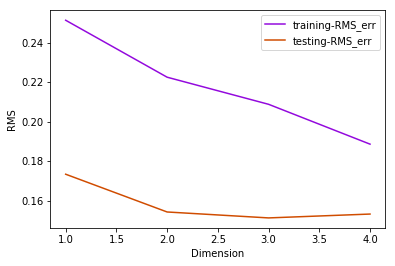

In [8]:
# visualize result
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
plt.plot(range(1,5),tr_rms_ary ,color=colors[1], label='training-RMS_err'.format(i=0))
plt.plot(range(1,5),ts_rms_ary ,color=colors[2], label='testing-RMS_err'.format(i=1))
#          'ro-', label='training-RMSerr'.format(0),range(1,10),ts_rms_ary,'bo-',label='testing-RMSerr'.format(0))
# plt.axis([0, 6, 0, 20])
plt.legend(loc='best')
plt.xlabel('Dimension')
plt.ylabel('RMS')
# plt.savefig('hw1-5-additional_test.png')

plt.show()
plt.close(fig)

In [9]:
# # export to python file
# !jupyter nbconvert --to python hw1-5_polynomial_regression.ipynb